#  Прогнозирование заказов такси

## Содержание
* 1  Подготовка
* 2  Анализ
* 3  Обучение
    * 3.1  Линейная регрессия
    * 3.2  Случайный лес
    * 3.3  Light GBM
    * 3.4  CatBoost
* 4  Тестирование

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## 1 Подготовка

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px # подключаем графическую библиотеку plotly
from IPython.display import display #импортируем метод дисплей для красивого вывода таблиц (не применяя print)
pd.set_option('display.max_columns', None) #реализуем возможность вывода всех столбцов на экран
pd.set_option('display.float_format', '{:.3f}'.format) #выводим значения float до 3 знаков после запятой
from sklearn.preprocessing import StandardScaler # для масштабирования количественных признаков
from sklearn.preprocessing import OrdinalEncoder # порядковое кодирование
from sklearn.model_selection import train_test_split # деление на 2 выборки
from sklearn.model_selection import GridSearchCV # для поиска оптимальных параметров
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error # для расчета MSE и RMSE
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('taxi.csv', sep=',', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Выполним ресемплирование данных по одному часу.

In [6]:
df = df.resample('1H').sum()
display(df.head())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## 2 Анализ

Проверим данные на монотонность.

In [7]:
print(df.index.is_monotonic)

True


Данные монотонны. Выведем график изменения данных.

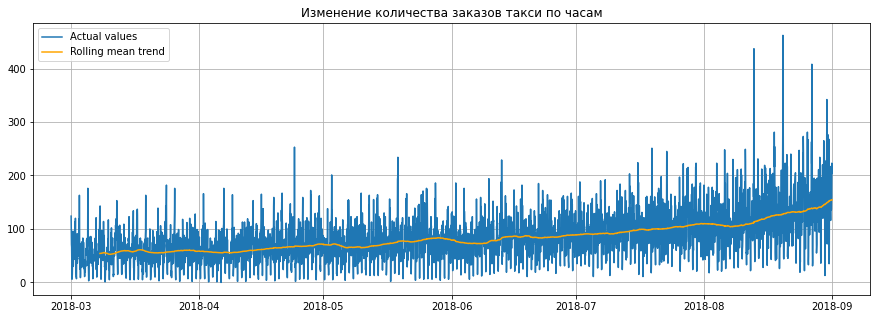

In [9]:
rolling_mean = df.rolling(24*7).mean()

plt.figure(figsize=(15,5))
plt.title("Изменение количества заказов такси по часам")

plt.plot(df, label="Actual values")
plt.plot(rolling_mean, "g", label="Rolling mean trend", color='orange')
plt.legend(loc="upper left")
plt.grid(True)

Благодаря скользящему среднему с размером окна в 1 неделю мы видим, что происходит непрерывный рост количества заказов такси. Скорей всего взяты данные по заказам такси города, часто посещаемого туристами.

Посмотрим тренды и сезонность.

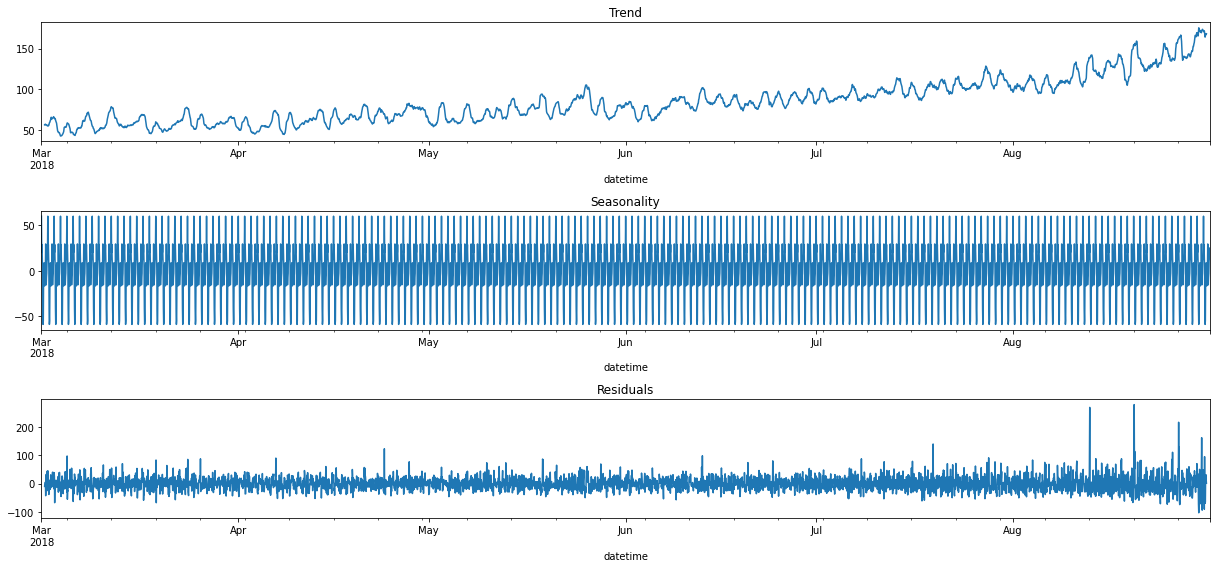

In [10]:
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(17, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

График тренда подтвердил выявленную возрастающую зависимость. График сезонности скорей всего показывает сезонность внутри одного дня. Посмотрим его детальнее.

<AxesSubplot:title={'center':'Сезонность заказов в течение 7 дней'}, xlabel='datetime'>

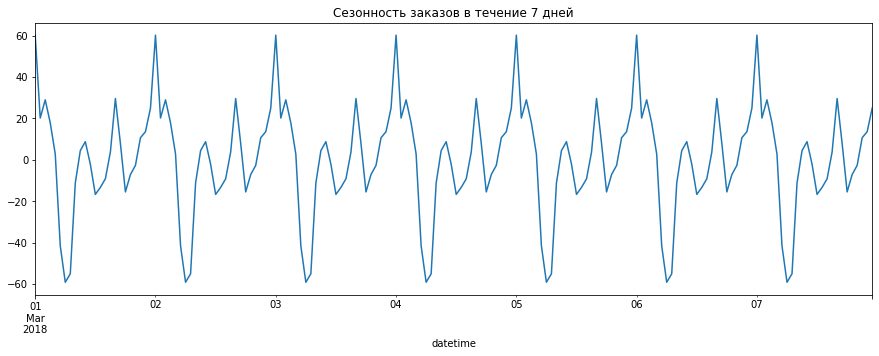

In [11]:
plt.figure(figsize=(15,5))
plt.title("Сезонность заказов в течение 7 дней")
decomposed.seasonal['2018-03-01':'2018-03-7'].plot(ax=plt.gca())

Сезонность в данном случае проявляется в одинаковом поведении заказов внутри одного дня: самый пик приходится на полночь - видимо люди возвращаются домой с гостей и мест отдыха, спад идет перед утренними часами и также значительное возрастание к вечернему времени - одни люди едут домой с работы, другие - отдыхать.

Проверим, можно ли назвать наш график стационарным, для этого используем тест Дики-Фуллера.

In [9]:
print('p-value гипотизы о нестационарности временного ряда составил', round(sm.tsa.stattools.adfuller(df['num_orders'])[1], 3))

p-value гипотизы о нестационарности временного ряда составил 0.029


В качестве критерия значимости примем 5 %, поэтому будем считать график стационарным.

Итак, пропусков в данных нет, временной ряд монотонен и стационарен, предобработка данных не требуется. Также был выделен тренд имеющий возрастающую зависимость от времени и сезонность по дням. Переходим к подготовке выборок и обучению моделей.

## 3 Обучение

Создадим дополнительные признаки для последующего обучения моделей. Т.к. стоит задача краткосрочного прогноза (на час вперед), то такие признаки как день недели, месяц и год включать не будем. Добавим лаги на 24 часа, скользяещее среднее с горизонтом в 7 часов, час и день.

In [12]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    return data

In [13]:
df_1 = make_features(df, 2, 24)

In [14]:
df_1.head(25)

,num_orders,hour,dayofweek,rolling_mean,lag_1,lag_2
datetime,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,NaN,124.000,NaN
2018-03-01 02:00:00,71,2,3,NaN,85.000,124.000
2018-03-01 03:00:00,66,3,3,NaN,71.000,85.000
2018-03-01 04:00:00,43,4,3,NaN,66.000,71.000
2018-03-01 05:00:00,6,5,3,NaN,43.000,66.000
2018-03-01 06:00:00,12,6,3,NaN,6.000,43.000
2018-03-01 07:00:00,15,7,3,NaN,12.000,6.000
2018-03-01 08:00:00,34,8,3,NaN,15.000,12.000


Разделим данные на обучающую и тестовые выборки и проверим корректность деления.

In [15]:
train, test = train_test_split(df_1, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Деление произведено корректно. Избавимся от пропусков в трейне.

In [16]:
train.dropna(inplace=True)

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3950 entries, 2018-03-02 00:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    3950 non-null   int64  
 1   hour          3950 non-null   int64  
 2   dayofweek     3950 non-null   int64  
 3   rolling_mean  3950 non-null   float64
 4   lag_1         3950 non-null   float64
 5   lag_2         3950 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 216.0 KB


Создадим обучающие и целевой признак.

In [18]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

Создадим функцию для вычисления метрики RMSE. Далее она будет использована при подборе гиперпраметров.

In [19]:
def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse
scorer = make_scorer(rmse_score, greater_is_better=False)

Переходим к обучению различных моделей. Проверим действие 4-х моделей: линейная регрессия, случайный лес, LightGBM, CatBoost. Поиск гиперпараметров будем проводить с помощью метода RandoSearchCV и метода TimeSeriesSplit.

### 3.1 Линейная регрессия

In [20]:
tscv = TimeSeriesSplit(n_splits=8)

In [24]:
'''model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid = RandomizedSearchCV(model, parameters, cv=tscv, scoring=scorer, verbose=5, n_jobs=-1)
grid.fit(features_train, target_train)
print("RMSE линейной регрессии составляет ", -grid.best_score_)
print('Наилучшие подобранные параметры для линейной регрессии')
grid.best_params_'''

'model = LinearRegression()\nparameters = {\'fit_intercept\':[True,False], \'normalize\':[True,False]}\ngrid = RandomizedSearchCV(model, parameters, cv=tscv, scoring=scorer, verbose=5, n_jobs=-1)\ngrid.fit(features_train, target_train)\nprint("RMSE линейной регрессии составляет ", -grid.best_score_)\nprint(\'Наилучшие подобранные параметры для линейной регрессии\')\ngrid.best_params_'

Наилучший RMSE **31.36** получен для параметров: 'fit_intercept': False, 'normalize': True. **Код выше закоментирован, чтобы не выполнялся снова при перезапуске тетрадки.**

### 3.2 Случайный лес

In [26]:
'''forest = RandomForestRegressor(random_state=12345)
    
forest_params = {'n_estimators': range(30, 151, 10),
                 'max_depth': range(1,15)}

forest_grid = RandomizedSearchCV(forest, forest_params, cv=tscv, 
                                 scoring=scorer, verbose=5, n_jobs=-1)
forest_grid.fit(features_train, target_train)

print("RMSE для случайного леса составляет ", -forest_grid.best_score_)


print('Наилучшие подобранные параметры для случайного леса')
print(forest_grid.best_params_)'''

'forest = RandomForestRegressor(random_state=12345)\n    \nforest_params = {\'n_estimators\': range(30, 151, 10),\n                 \'max_depth\': range(1,15)}\n\nforest_grid = RandomizedSearchCV(forest, forest_params, cv=tscv, \n                                 scoring=scorer, verbose=5, n_jobs=-1)\nforest_grid.fit(features_train, target_train)\n\nprint("RMSE для случайного леса составляет ", -forest_grid.best_score_)\n\n\nprint(\'Наилучшие подобранные параметры для случайного леса\')\nprint(forest_grid.best_params_)'

Наилучший RMSE **24.587** для случайного леса получен для параметров: 'max_depth': 14, 'n_estimators': 150. **Код выше закоментирован, чтобы не выполнялся снова при перезапуске тетрадки.**

### 3.3 Light GBM

In [28]:
'''gbm = LGBMRegressor(random_state=12345)
    
g_params = {'n_estimators': [50, 100, 500],
              'num_leaves': [21, 31, 41], 
              'learning_rate':[0.01, .04, 0.06]}

g_grid = RandomizedSearchCV(gbm, g_params,
                         cv=tscv, verbose=5, scoring=scorer)

g_grid.fit(features_train, target_train)

print("RMSE для LGBM составляет ", -g_grid.best_score_)


print('Наилучшие подобранные параметры для LGBM')
print(g_grid.best_params_)'''

'gbm = LGBMRegressor(random_state=12345)\n    \ng_params = {\'n_estimators\': [50, 100, 500],\n              \'num_leaves\': [21, 31, 41], \n              \'learning_rate\':[0.01, .04, 0.06]}\n\ng_grid = RandomizedSearchCV(gbm, g_params,\n                         cv=tscv, verbose=5, scoring=scorer)\n\ng_grid.fit(features_train, target_train)\n\nprint("RMSE для LGBM составляет ", -g_grid.best_score_)\n\n\nprint(\'Наилучшие подобранные параметры для LGBM\')\nprint(g_grid.best_params_)'

Наилучший RMSE **24.36** для LGBM получен для параметров: 'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 31. **Код выше закоментирован, чтобы не выполнялся снова при перезапуске тетрадки.**

### 3.4 CatBoost

In [29]:
'''cbr = CatBoostRegressor(loss_function="RMSE")

grid = {'learning_rate': [0.03, 0.1, 0.5],
        'iterations': [150, 500]}

cbr_grid = RandomizedSearchCV(cbr, grid,
                         cv=tscv, verbose=5, scoring=scorer)

cbr_grid.fit(features_train, target_train)

print("RMSE для CBR составляет ", -cbr_grid.best_score_)


print('Наилучшие подобранные параметры для CBR')
print(cbr_grid.best_params_)'''

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning:

The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 8 folds for each of 6 candidates, totalling 48 fits
[CV] learning_rate=0.03, iterations=150 ..............................
0:	learn: 28.8716013	total: 48.7ms	remaining: 7.26s
1:	learn: 28.6397491	total: 49.7ms	remaining: 3.68s
2:	learn: 28.2343951	total: 50.6ms	remaining: 2.48s
3:	learn: 27.8053861	total: 51.5ms	remaining: 1.88s
4:	learn: 27.4370010	total: 52.5ms	remaining: 1.52s
5:	learn: 27.1426815	total: 53.4ms	remaining: 1.28s
6:	learn: 26.8085840	total: 54.3ms	remaining: 1.11s
7:	learn: 26.4351619	total: 55.2ms	remaining: 980ms
8:	learn: 26.0912440	total: 56.1ms	remaining: 879ms
9:	learn: 25.7699476	total: 57.1ms	remaining: 800ms
10:	learn: 25.5334583	total: 58ms	remaining: 733ms
11:	learn: 25.3325137	total: 58.9ms	remaining: 677ms
12:	learn: 25.0579611	total: 63.9ms	remaining: 673ms
13:	learn: 24.9022981	total: 65.3ms	remaining: 634ms
14:	learn: 24.6015342	total: 67.5ms	remaining: 608ms
15:	learn: 24.3271828	total: 69.3ms	remaining: 580ms
16:	learn: 24.0496988	total: 71ms

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


0:	learn: 29.1244556	total: 2.33ms	remaining: 347ms
1:	learn: 28.8819110	total: 3.89ms	remaining: 288ms
2:	learn: 28.6023574	total: 5.51ms	remaining: 270ms
3:	learn: 28.2021466	total: 7.19ms	remaining: 262ms
4:	learn: 27.8355595	total: 9.34ms	remaining: 271ms
5:	learn: 27.5121122	total: 11.1ms	remaining: 266ms
6:	learn: 27.1829867	total: 12.7ms	remaining: 260ms
7:	learn: 26.8538564	total: 14.1ms	remaining: 250ms
8:	learn: 26.5411383	total: 15.5ms	remaining: 243ms
9:	learn: 26.2384619	total: 17.1ms	remaining: 239ms
10:	learn: 26.0101781	total: 63.6ms	remaining: 804ms
11:	learn: 25.7443090	total: 65.1ms	remaining: 748ms
12:	learn: 25.4720148	total: 66.7ms	remaining: 703ms
13:	learn: 25.2821844	total: 68.7ms	remaining: 667ms
14:	learn: 25.0111825	total: 70.2ms	remaining: 632ms
15:	learn: 24.7414024	total: 71.6ms	remaining: 600ms
16:	learn: 24.5058743	total: 73.2ms	remaining: 573ms
17:	learn: 24.2529108	total: 74.7ms	remaining: 548ms
18:	learn: 24.0407162	total: 76.5ms	remaining: 528ms
19:

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s


0:	learn: 30.0956995	total: 1.55ms	remaining: 232ms
1:	learn: 29.7340219	total: 3.3ms	remaining: 245ms
2:	learn: 29.4309981	total: 4.64ms	remaining: 228ms
3:	learn: 29.1063692	total: 5.84ms	remaining: 213ms
4:	learn: 28.7790740	total: 7.28ms	remaining: 211ms
5:	learn: 28.4771640	total: 8.52ms	remaining: 204ms
6:	learn: 28.1549307	total: 9.76ms	remaining: 199ms
7:	learn: 27.8301857	total: 11ms	remaining: 194ms
8:	learn: 27.5319851	total: 66.4ms	remaining: 1.04s
9:	learn: 27.2747967	total: 67.9ms	remaining: 950ms
10:	learn: 27.0372346	total: 69.1ms	remaining: 873ms
11:	learn: 26.7631996	total: 70.2ms	remaining: 808ms
12:	learn: 26.5246584	total: 72.7ms	remaining: 766ms
13:	learn: 26.3831540	total: 73.8ms	remaining: 717ms
14:	learn: 26.1774430	total: 75ms	remaining: 675ms
15:	learn: 25.9485603	total: 76.3ms	remaining: 639ms
16:	learn: 25.7036262	total: 77.5ms	remaining: 606ms
17:	learn: 25.4664483	total: 163ms	remaining: 1.19s
18:	learn: 25.2848188	total: 164ms	remaining: 1.13s
19:	learn:

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.1s remaining:    0.0s


0:	learn: 31.0025194	total: 1.7ms	remaining: 254ms
1:	learn: 30.6326732	total: 3.2ms	remaining: 237ms
2:	learn: 30.3236697	total: 4.61ms	remaining: 226ms
3:	learn: 29.9521906	total: 5.85ms	remaining: 214ms
4:	learn: 29.6067320	total: 7.21ms	remaining: 209ms
5:	learn: 29.2589288	total: 8.46ms	remaining: 203ms
6:	learn: 28.9355622	total: 9.83ms	remaining: 201ms
7:	learn: 28.6005653	total: 11.2ms	remaining: 198ms
8:	learn: 28.3247216	total: 12.5ms	remaining: 195ms
9:	learn: 28.0544999	total: 13.8ms	remaining: 193ms
10:	learn: 27.8291999	total: 15ms	remaining: 190ms
11:	learn: 27.5523263	total: 16.2ms	remaining: 187ms
12:	learn: 27.3250000	total: 17.6ms	remaining: 186ms
13:	learn: 27.0489348	total: 18.9ms	remaining: 183ms
14:	learn: 26.7946140	total: 25.5ms	remaining: 230ms
15:	learn: 26.5545427	total: 108ms	remaining: 901ms
16:	learn: 26.3208049	total: 109ms	remaining: 854ms
17:	learn: 26.0734461	total: 111ms	remaining: 811ms
18:	learn: 25.9035740	total: 112ms	remaining: 772ms
19:	learn: 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.3s remaining:    0.0s


0:	learn: 32.5506266	total: 3.2ms	remaining: 477ms
1:	learn: 32.1707938	total: 6.64ms	remaining: 491ms
2:	learn: 31.7929610	total: 11.8ms	remaining: 578ms
3:	learn: 31.4301599	total: 16.3ms	remaining: 594ms
4:	learn: 31.0699857	total: 79.9ms	remaining: 2.32s
5:	learn: 30.7017370	total: 82.9ms	remaining: 1.99s
6:	learn: 30.4039217	total: 86.4ms	remaining: 1.76s
7:	learn: 30.0640271	total: 91ms	remaining: 1.61s
8:	learn: 29.7433686	total: 176ms	remaining: 2.76s
9:	learn: 29.4826219	total: 178ms	remaining: 2.48s
10:	learn: 29.1932920	total: 179ms	remaining: 2.26s
11:	learn: 28.9231936	total: 181ms	remaining: 2.08s
12:	learn: 28.6453406	total: 182ms	remaining: 1.92s
13:	learn: 28.3784526	total: 184ms	remaining: 1.78s
14:	learn: 28.1175985	total: 185ms	remaining: 1.67s
15:	learn: 27.8742789	total: 197ms	remaining: 1.65s
16:	learn: 27.6449996	total: 273ms	remaining: 2.13s
17:	learn: 27.4008487	total: 275ms	remaining: 2.01s
18:	learn: 27.2113001	total: 276ms	remaining: 1.91s
19:	learn: 26.984

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  5.2min finished


0:	learn: 38.1593509	total: 10.5ms	remaining: 5.23s
1:	learn: 37.6528634	total: 15.6ms	remaining: 3.87s
2:	learn: 37.2322117	total: 103ms	remaining: 17.1s
3:	learn: 36.7332280	total: 110ms	remaining: 13.6s
4:	learn: 36.2070462	total: 117ms	remaining: 11.6s
5:	learn: 35.7394490	total: 203ms	remaining: 16.8s
6:	learn: 35.2697734	total: 210ms	remaining: 14.8s
7:	learn: 34.8547324	total: 216ms	remaining: 13.3s
8:	learn: 34.4262300	total: 299ms	remaining: 16.3s
9:	learn: 34.1103335	total: 301ms	remaining: 14.7s
10:	learn: 33.7559989	total: 303ms	remaining: 13.4s
11:	learn: 33.3836671	total: 307ms	remaining: 12.5s
12:	learn: 33.0600783	total: 404ms	remaining: 15.1s
13:	learn: 32.7215958	total: 409ms	remaining: 14.2s
14:	learn: 32.3665543	total: 415ms	remaining: 13.4s
15:	learn: 32.0464336	total: 501ms	remaining: 15.2s
16:	learn: 31.7595585	total: 516ms	remaining: 14.7s
17:	learn: 31.4449848	total: 518ms	remaining: 13.9s
18:	learn: 31.1983720	total: 573ms	remaining: 14.5s
19:	learn: 30.922731

Наилучший RMSE **24.669** для CBR получен для параметров: 'iterations': 500, 'learning_rate': 0.03. **Код выше закоментирован, чтобы не выполнялся снова при перезапуске тетрадки.**

Обучены и подобраны гиперпараметры для 4 различных моделей: линейная регрессия, случайный лес, CatBoost, LightGBM. Для всех моделей была применена кросс-валидация с применением метода TimeSeriesSplit.
    
Целевое значение метрики RMSE (<48) достигнуты всеми 4-мя моделями. Наихудший результат был получен с ппомощью линейной регрессии (31.36), наилучший - с помощью **LGBM** (**24.36**). Проверим модели с подобранными гиперпараметрами на тестовой выборке.

## 4 Тестирование

In [21]:
# создадим таблицу для хранения результатов
d = {'model': [], 'RMSE':[], 'fit_time': [], 'predict_time':[]}
results = pd.DataFrame(data=d)
results

,model,RMSE,fit_time,predict_time


In [22]:
# создадим функцию для добавления результатов в таблицу
def model_res(model_name, model, features_train, target_train, features_test, target_test):
    rmse, fit_time, pred_time = ml(model, features_train, target_train, features_test, target_test)
    results.loc[len(results)] = [model_name, rmse, fit_time, pred_time]
    if len(results) > 0: # исключим дублировании при неоднократном выполнении функции для одной и той же модели
        results.drop_duplicates(inplace=True)

In [23]:
# cоздадим функцию для расчета необходимых параметров
def ml (model, features_train, target_train, features_test, target_test):
    start_fit_time = time.time()
    model.fit(features_train, target_train)
    stop_fit_time = time.time()
    
    fit_time = stop_fit_time - start_fit_time
    
    start_predict_time = time.time()
    predictions = model.predict(features_test)
    
    stop_predict_time = time.time()
    
    pred_time = stop_predict_time - start_predict_time
    
    rmse = mean_squared_error(target_test, predictions)**0.5
    
    return rmse, fit_time, pred_time

In [24]:
# создадим функцию для вывода графиков
def plot_test (model, model_name):
    plt.figure(figsize=(15,5))
    plt.title("Сравнение реальных значений и предсказанных с помощью модели " + model_name)
    plt.plot(target_test, label='Test values')
    predictions = model.predict(features_test)
    predictions = pd.Series(predictions, index=target_test.index)
    plt.plot(predictions, label ='Prediction values')
    plt.legend(loc="upper left")
    plt.grid(True)

,model,RMSE,fit_time,predict_time
0,LinearRegression,51.192,0.005,0.002


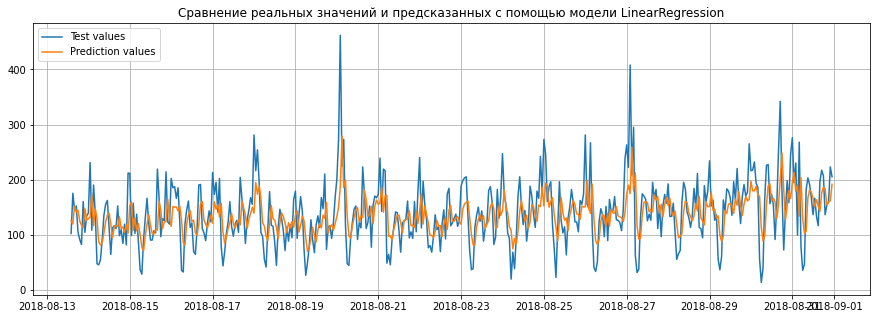

In [25]:
# линейная регрессия
lr = LinearRegression(fit_intercept=False, normalize=True)
model_res('LinearRegression', lr,  features_train, target_train,
          features_test, target_test)
display(results)
plot_test(lr, 'LinearRegression')

На тестовой выборке линейная регрессия показала намного меньший результат, чем на трейне, **и вывалилась за предельное значение метрики**. График показывает, что, в основном, линейная регрессия больше всего ошибается в точках максимумов и минимумов.

,model,RMSE,fit_time,predict_time
0,LinearRegression,51.192,0.005,0.002
1,RandomForestRegressor,46.718,1.403,0.022


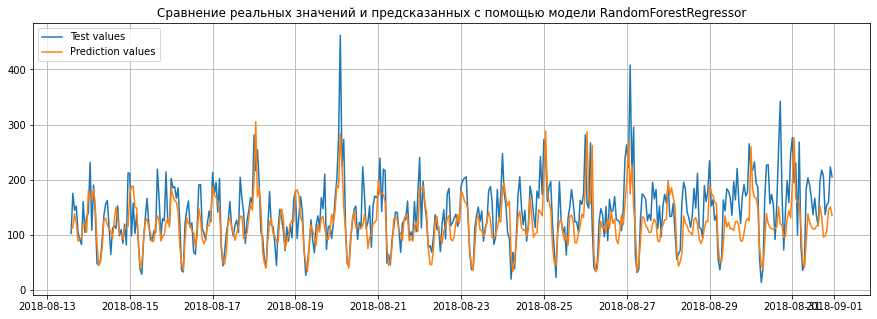

In [26]:
# случайный лес
rf = RandomForestRegressor(max_depth=14, n_estimators=150, random_state=12345)
model_res('RandomForestRegressor', rf,  features_train, target_train,
          features_test, target_test)
display(results)
plot_test(rf, 'RandomForestRegressor')

Метрика случайного леса получилась лучше, чем у линейной регрессии, **и вошла в допустимый интервал**.

,model,RMSE,fit_time,predict_time
0,LinearRegression,51.192,0.005,0.002
1,RandomForestRegressor,46.718,1.403,0.022
2,LGBMRegressor,45.082,0.828,0.008


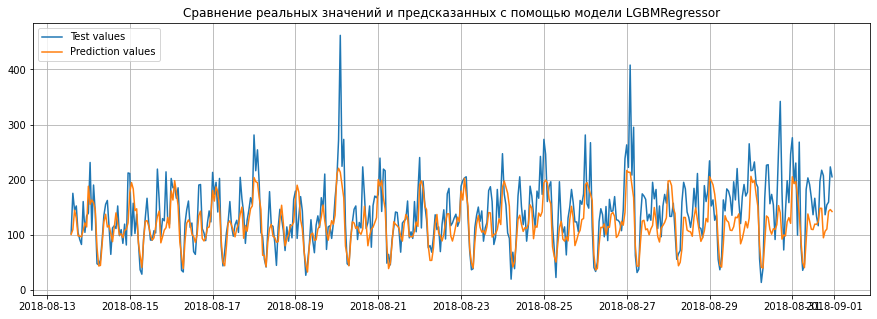

In [27]:
# Light GBM
lgbm = LGBMRegressor(learning_rate=0.01, n_estimators=500, num_leaves=41, random_state=12345)
model_res('LGBMRegressor', lgbm,  features_train, target_train,
          features_test, target_test)
display(results)
plot_test(lgbm, 'LGBMRegressor')

RMSE у LGBM почти такая же как у случайного леса, а скорость обучения в 2 раза больше, поэтому в качестве лидера пока можно выделить случайный лес.

0:	learn: 38.0839188	total: 158ms	remaining: 1m 19s
1:	learn: 37.5599621	total: 168ms	remaining: 41.8s
2:	learn: 37.0857594	total: 177ms	remaining: 29.4s
3:	learn: 36.6055784	total: 185ms	remaining: 22.9s
4:	learn: 36.1223956	total: 189ms	remaining: 18.7s
5:	learn: 35.7032658	total: 194ms	remaining: 15.9s
6:	learn: 35.2992283	total: 198ms	remaining: 13.9s
7:	learn: 34.8873800	total: 202ms	remaining: 12.4s
8:	learn: 34.4810575	total: 207ms	remaining: 11.3s
9:	learn: 34.1085164	total: 210ms	remaining: 10.3s
10:	learn: 33.7147967	total: 213ms	remaining: 9.46s
11:	learn: 33.3666613	total: 215ms	remaining: 8.74s
12:	learn: 33.0015923	total: 217ms	remaining: 8.13s
13:	learn: 32.7239535	total: 219ms	remaining: 7.61s
14:	learn: 32.3654645	total: 221ms	remaining: 7.15s
15:	learn: 32.0235319	total: 223ms	remaining: 6.75s
16:	learn: 31.7140120	total: 225ms	remaining: 6.4s
17:	learn: 31.4655993	total: 227ms	remaining: 6.08s
18:	learn: 31.1636224	total: 229ms	remaining: 5.8s
19:	learn: 30.8760894	t

219:	learn: 22.0546072	total: 653ms	remaining: 831ms
220:	learn: 22.0459831	total: 655ms	remaining: 827ms
221:	learn: 22.0268841	total: 657ms	remaining: 823ms
222:	learn: 22.0098268	total: 659ms	remaining: 819ms
223:	learn: 21.9884234	total: 661ms	remaining: 815ms
224:	learn: 21.9729101	total: 663ms	remaining: 811ms
225:	learn: 21.9581090	total: 665ms	remaining: 807ms
226:	learn: 21.9388757	total: 668ms	remaining: 803ms
227:	learn: 21.9238033	total: 670ms	remaining: 799ms
228:	learn: 21.9126359	total: 672ms	remaining: 795ms
229:	learn: 21.9027524	total: 674ms	remaining: 792ms
230:	learn: 21.8910208	total: 676ms	remaining: 788ms
231:	learn: 21.8740898	total: 679ms	remaining: 784ms
232:	learn: 21.8627999	total: 681ms	remaining: 780ms
233:	learn: 21.8416653	total: 683ms	remaining: 777ms
234:	learn: 21.8213356	total: 685ms	remaining: 773ms
235:	learn: 21.8077832	total: 688ms	remaining: 769ms
236:	learn: 21.8044989	total: 690ms	remaining: 765ms
237:	learn: 21.7991329	total: 692ms	remaining:

425:	learn: 20.1085013	total: 1.13s	remaining: 196ms
426:	learn: 20.0946123	total: 1.13s	remaining: 193ms
427:	learn: 20.0794496	total: 1.13s	remaining: 191ms
428:	learn: 20.0720162	total: 1.14s	remaining: 188ms
429:	learn: 20.0593745	total: 1.14s	remaining: 186ms
430:	learn: 20.0520087	total: 1.14s	remaining: 183ms
431:	learn: 20.0447247	total: 1.14s	remaining: 180ms
432:	learn: 20.0347419	total: 1.15s	remaining: 177ms
433:	learn: 20.0232961	total: 1.15s	remaining: 175ms
434:	learn: 20.0161859	total: 1.15s	remaining: 172ms
435:	learn: 20.0068421	total: 1.15s	remaining: 169ms
436:	learn: 19.9944645	total: 1.16s	remaining: 167ms
437:	learn: 19.9862276	total: 1.16s	remaining: 164ms
438:	learn: 19.9783949	total: 1.16s	remaining: 161ms
439:	learn: 19.9696487	total: 1.16s	remaining: 159ms
440:	learn: 19.9630212	total: 1.17s	remaining: 156ms
441:	learn: 19.9595236	total: 1.17s	remaining: 153ms
442:	learn: 19.9483601	total: 1.17s	remaining: 151ms
443:	learn: 19.9405601	total: 1.17s	remaining:

,model,RMSE,fit_time,predict_time
0,LinearRegression,51.192,0.005,0.002
1,RandomForestRegressor,46.718,1.403,0.022
2,LGBMRegressor,45.082,0.828,0.008
3,CatBoostRegressor,46.903,1.962,0.024


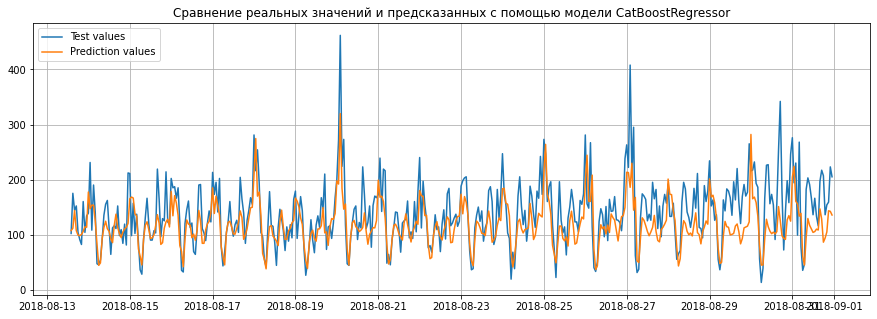

In [28]:
# CatBoost
cb = CatBoostRegressor(loss_function="RMSE",
                         learning_rate=0.03, 
                         iterations=500,
                         random_state=12345)
model_res('CatBoostRegressor', cb,  features_train, target_train,
          features_test, target_test)
display(results)
plot_test(cb, 'CatBoostRegressor')

По итогу тестирования все модели, **кроме линейной регрессии,** подошли под требование по поставленной метрике (RMSE < 48). тем не менее каждая модель оказалась переобученной (**или недообученной**), т.к. результаты на тестовой выборке ухудшились почти в 1.5 раза для каждой модели по сравнению с обучающей.

С лучшими по итогу параметрами (метрика + скорость обучения) оказался случайный лес, данную модель и подобранные ей гиперпараметры принимаем за основную и передаем заказчику для предсказания заказов такси в следующий час.